In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-06-13 11:47:57.991065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 11:47:57.991153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 11:47:58.101085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available. Using GPU.")
else:
    print("No GPU available. Using CPU.")

Num GPUs Available:  2
GPU is available. Using GPU.


In [4]:
# Path of the dataset
data_dir = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/"

# Label map for categoriues
categories = ['Parasitized', 'Uninfected']
label_map = {categories: index for index, categories in enumerate(categories)}

In [5]:
# List for file path and corresponding labels

file_path = []
labels = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            file_path.append(os.path.join(category_path, filename))
            labels.append(label_map[category])

In [6]:
# Converting file and labels to tensorflow datasets
file_path = tf.convert_to_tensor(file_path, dtype=tf.string)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)

In [7]:
# Creation of dataset from file path and labels?
dataset = tf.data.Dataset.from_tensor_slices((file_path, labels))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(file_path), seed=42)

In [8]:
dataset_size = len(file_path)
print(f"Dataset Size: {dataset_size}")

train_ratio = int(0.6 * dataset_size)
val_ratio = int(0.2 * dataset_size)
test_ratio = dataset_size - train_ratio - val_ratio

Dataset Size: 27558


In [9]:
train_dataset = dataset.take(train_ratio)
val_dataset = dataset.skip(train_ratio).take(val_ratio)
test_dataset = dataset.skip(train_ratio).skip(val_ratio)

In [10]:
print(f"train size: {len(train_dataset)}")
print(f"val size: {len(val_dataset)}")
print(f"test size: {len(test_dataset)}")

train size: 16534
val size: 5511
test size: 5513


In [11]:
for image, label in train_dataset.take(1):
    print("Image type:", type(image))
    print("Image:", image)
    print("Label:", label.numpy())

Image type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Image: tf.Tensor(b'/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C150P111ThinF_IMG_20151115_115950_cell_8.png', shape=(), dtype=string)
Label: 1


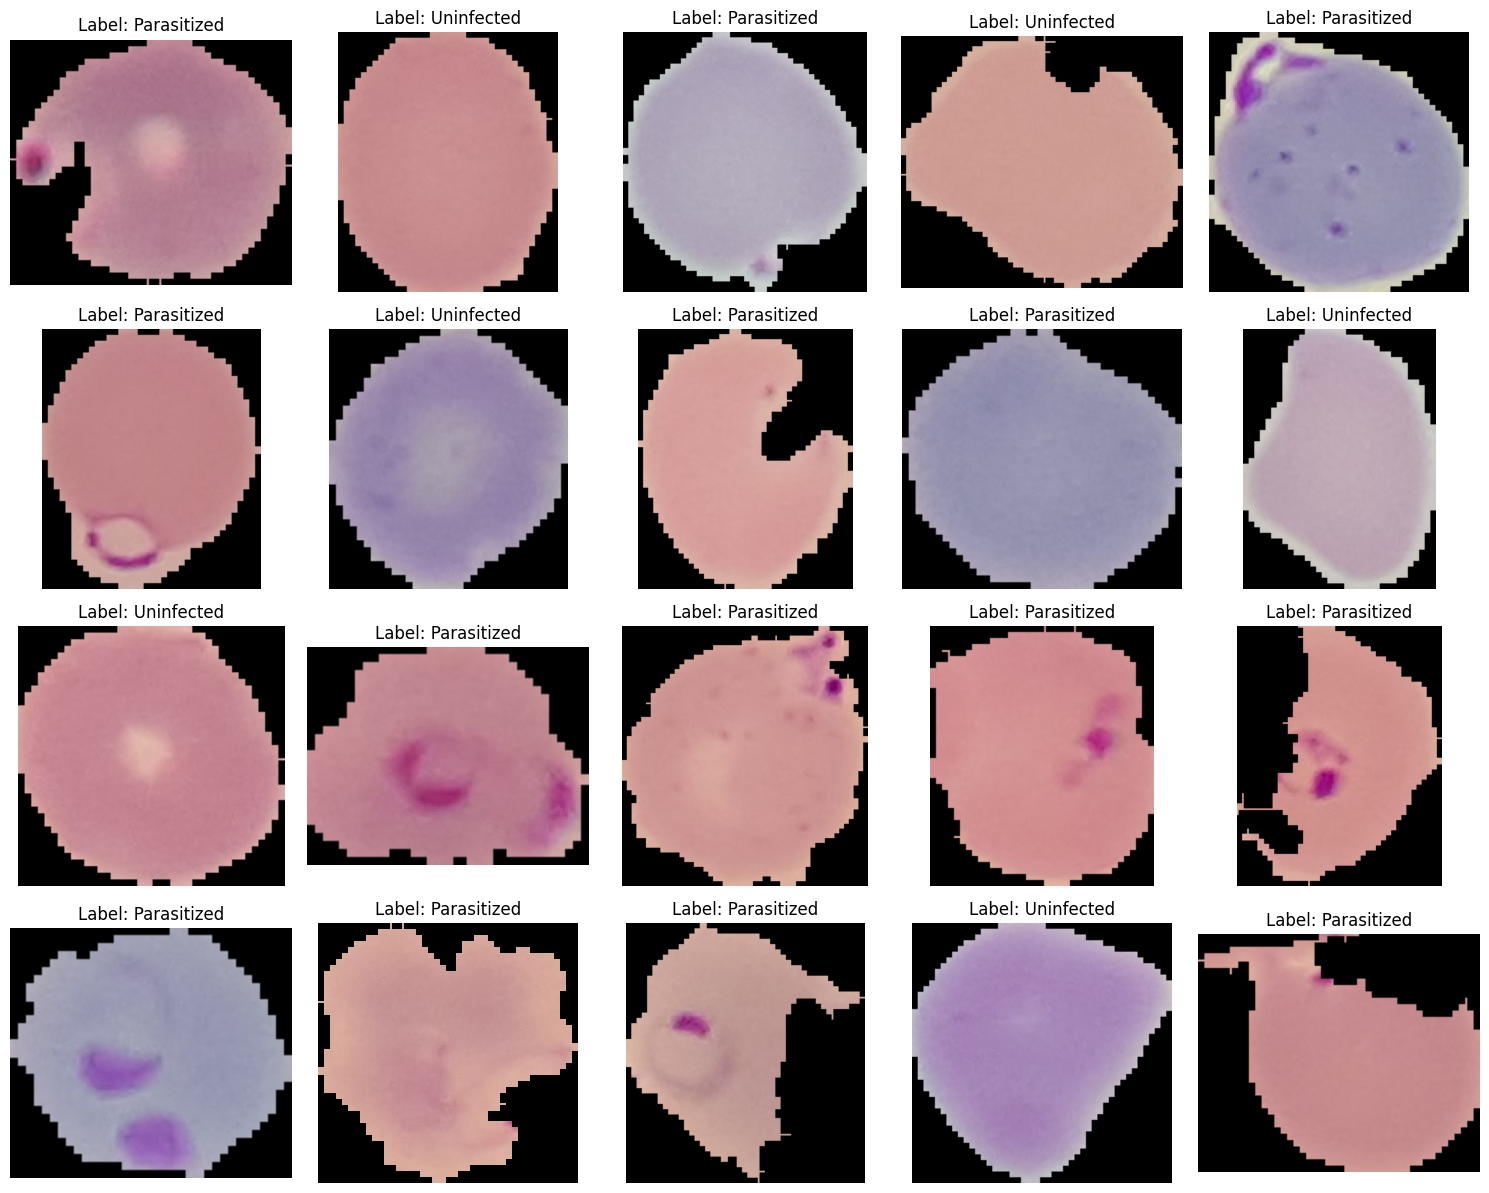

In [12]:
def load_and_preprocess_image(file_path):
    # Read the image file
    img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.image.decode_png(img, channels=3)
    # Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Plotting some images from the train dataset
plt.figure(figsize=(15, 15))
for i, (file_path, label) in enumerate(val_dataset.take(20)):
    ax = plt.subplot(5, 5, i + 1)
    
    # Load and preprocess the image
    image = load_and_preprocess_image(file_path)
    
    plt.imshow(image)
    plt.title(f"Label: {categories[label.numpy()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Function to load and preprocess images
def load_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])  # Ensure shape is known
    image = tf.image.resize(image, [224, 224])  # Resize to a fixed size if needed
    image = image / 255.0  # Normalize to [0, 1] range
    return image, label

In [14]:
# Apply the load_image function to the dataset
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

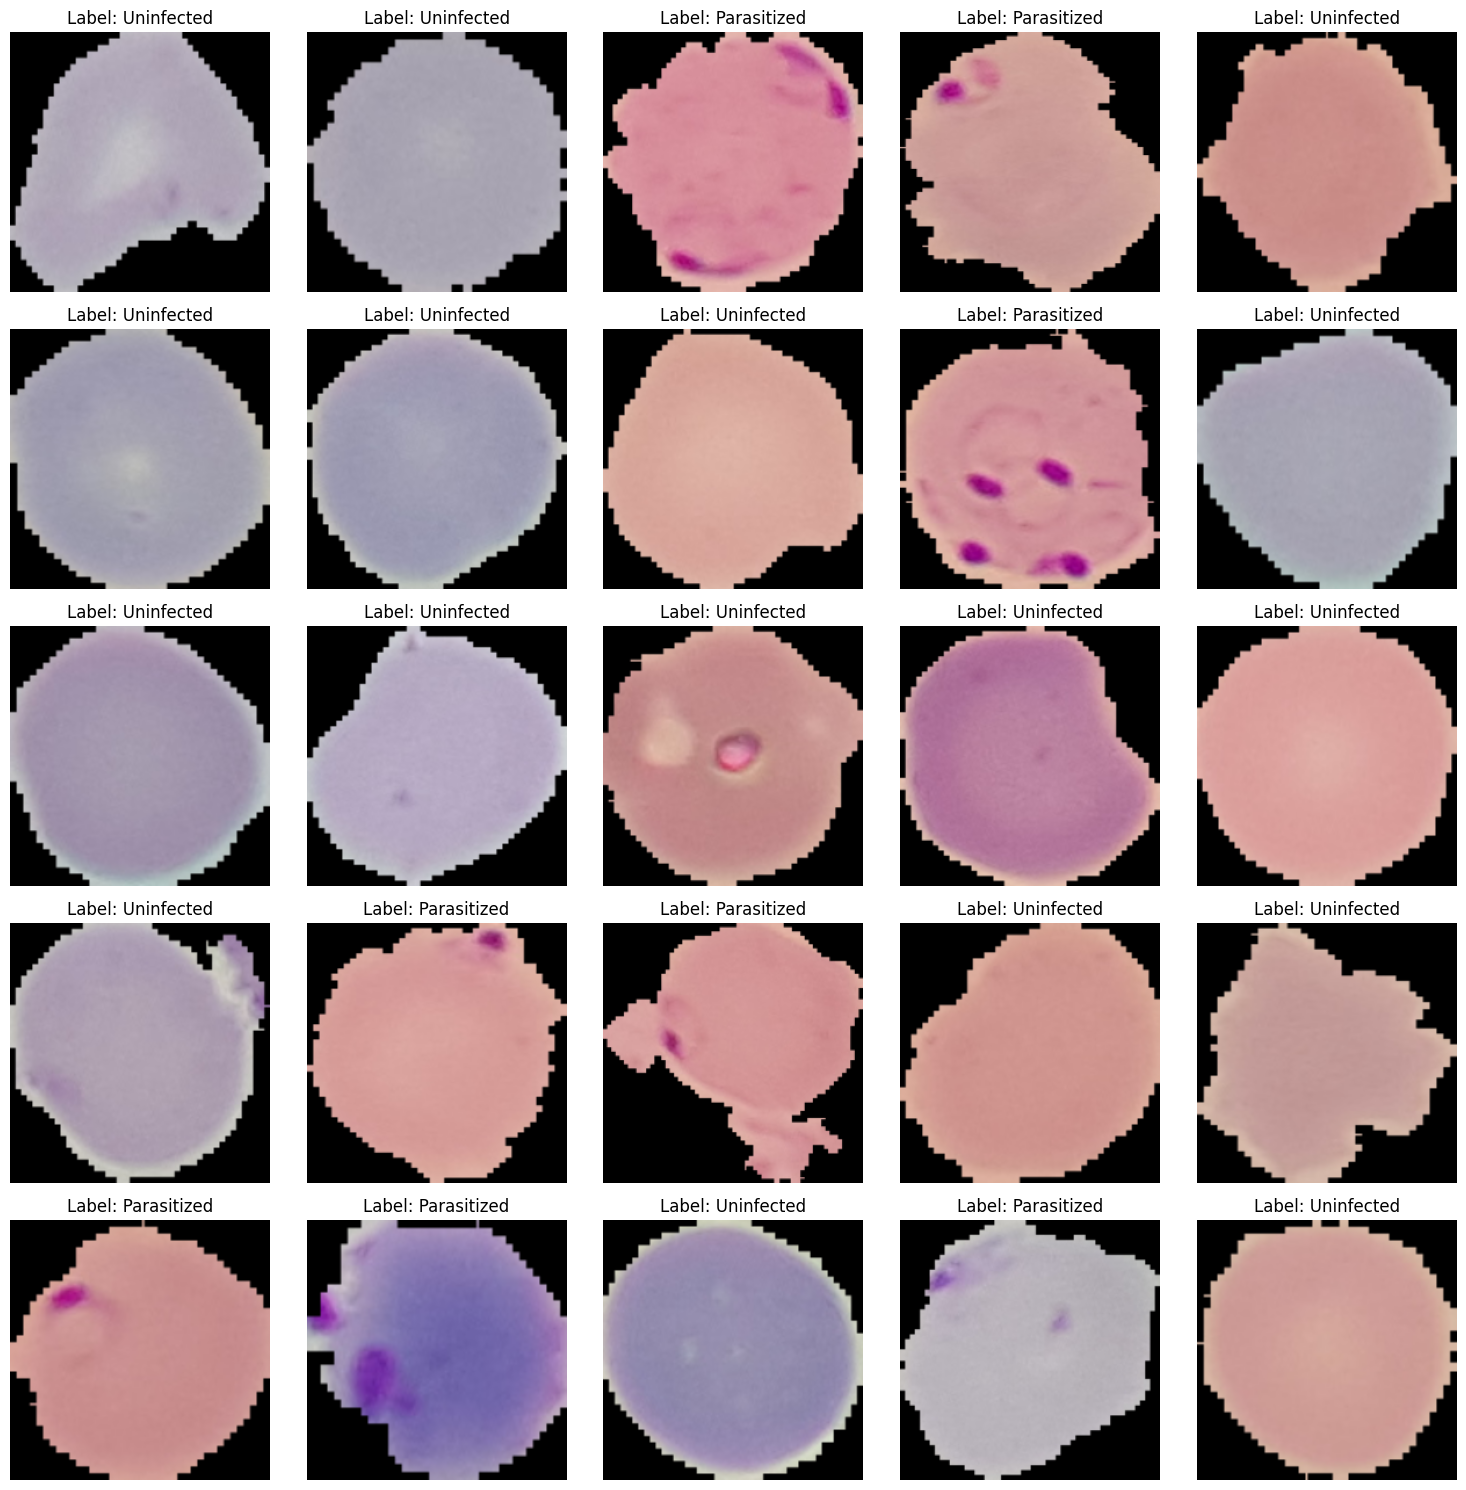

In [16]:
# Function to load and preprocess image for plotting
def load_and_preprocess_image(file_path):
    # Convert file_path to string if it's a tensor
    if isinstance(file_path, tf.Tensor):
        file_path = file_path.numpy().decode('utf-8')
    
    # Read the image file
    img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.image.decode_png(img, channels=3)
    # Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Plotting some images from the train dataset
plt.figure(figsize=(15, 15))
for i, (image, label) in enumerate(train_dataset.unbatch().take(25)):
    ax = plt.subplot(5, 5, i + 1)
    
    plt.imshow(image.numpy())
    plt.title(f"Label: {categories[label.numpy()]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras import models, layers

def create_resnet_model(input_shape=(224, 224, 3), num_classes=2):
    def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
        shortcut = x
        if conv_shortcut:
            shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Add()([shortcut, x])
        x = layers.ReLU()(x)
        
        return x
    
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = residual_block(x, 64, conv_shortcut=True)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [18]:
# Create and compile the model
with tf.device('/GPU:0'):  # Force the model to be created on GPU
    model = create_resnet_model(input_shape=(224, 224, 3))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

In [19]:
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 11,459,010 (43.71 MB)

 Trainable params: 11,449,282 (43.68 MB)

 Non-trainable params: 9,728 (38.00 KB)

In [20]:
# Train the model
with tf.device('/GPU:0'):  # Force training on GPU
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=15,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
        ]
    )

Epoch 1/15
  1/517 ━━━━━━━━━━━━━━━━━━━━ 4:39:40 33s/step - accuracy: 0.4688 - loss: 1.1600

I0000 00:00:1718279330.844993     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718279330.890309     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6882 - loss: 0.7081

W0000 00:00:1718279403.089771     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718279405.033109     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


517/517 ━━━━━━━━━━━━━━━━━━━━ 116s 162ms/step - accuracy: 0.6885 - loss: 0.7075 - val_accuracy: 0.9398 - val_loss: 0.1956 - learning_rate: 0.0010
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 62s 119ms/step - accuracy: 0.9560 - loss: 0.1429 - val_accuracy: 0.9565 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 61s 119ms/step - accuracy: 0.9600 - loss: 0.1382 - val_accuracy: 0.9592 - val_loss: 0.1339 - learning_rate: 0.0010
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 61s 119ms/step - accuracy: 0.9579 - loss: 0.1319 - val_accuracy: 0.9278 - val_loss: 0.2365 - learning_rate: 0.0010
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 62s 119ms/step - accuracy: 0.9576 - loss: 0.1405 - val_accuracy: 0.9584 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 61s 119ms/step - accuracy: 0.9612 - loss: 0.1240 - val_accuracy: 0.9548 - val_loss: 0.1518 - learning_rate: 0.0010
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 61s 119ms/step - accuracy: 0.9602 - loss

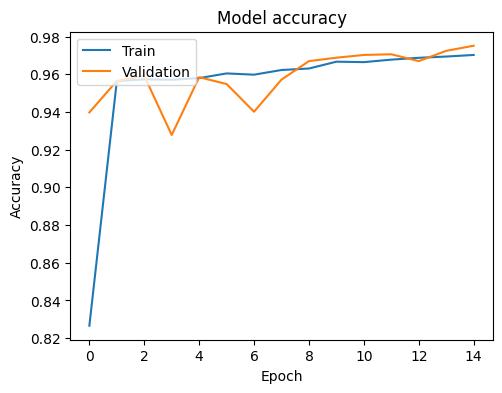

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

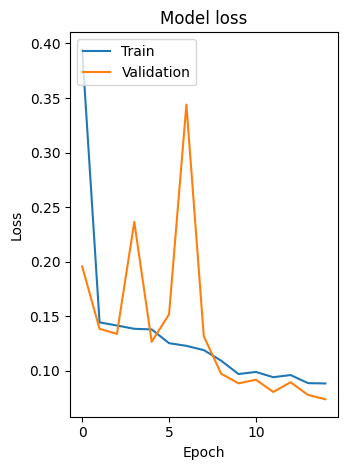

In [22]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [23]:
# Evaluate the model on validation set
val_loss, val_acc = model.evaluate(val_dataset)
print(f'Validation accuracy: {val_acc:.4f}')

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.4f}')

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9712 - loss: 0.0807
Validation accuracy: 0.9701
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9728 - loss: 0.0747
Test accuracy: 0.9742


In [24]:
# Save the model
model.save('saved_model/parasitized_cell_classifier.h5')
print("Model saved successfully.")

Model saved successfully.


In [25]:
# To demonstrate how to load the model:
loaded_model = tf.keras.models.load_model('saved_model/parasitized_cell_classifier.h5')
print("Model loaded successfully.")

Model loaded successfully.


In [26]:
# Visualize the architecture of the loaded model
loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 11,459,012 (43.71 MB)

 Trainable params: 11,449,282 (43.68 MB)

 Non-trainable params: 9,728 (38.00 KB)

 Optimizer params: 2 (12.00 B)

In [27]:
# Verify that the loaded model has the same test accuracy
test_loss, test_acc = loaded_model.evaluate(test_dataset)
print(f'Loaded model - Test accuracy: {test_acc:.4f}')

  4/173 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9590 - loss: 0.0793

W0000 00:00:1718280293.814037     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9731 - loss: 0.0723
Loaded model - Test accuracy: 0.9722
